# 🎵 Clasificación de Emociones con Redes Neuronales Cuánticas – Versión Refactorizada

Este cuaderno ha sido refactorizado para soportar **buenas prácticas de ingeniería de machine learning**: separación clara de *train/val/test*, registro de hiperparámetros, estructura de carpetas organizada y guardado de métricas/modelos.  

El objetivo es trabajar con el dataset **CREMA-D**, utilizando arquitecturas clásicas y cuánticas (PennyLane), basadas en espectrogramas precomputados, embeddings de redes preentrenadas o MFCCs. Las celdas están organizadas lógicamente para que el flujo de ejecución sea de arriba hacia abajo, sin dependencias ocultas.


In [14]:
# Environment setup: mount Drive and clone repository
# Mount Google Drive to access data stored in `/content/drive/MyDrive/CREMAD`
from google.colab import drive
drive.mount('/content/drive')
# Clone the repository (if necessary) and add `src` to the path
repo_path = '/content/qnn-transfer-learning'
import os
if not os.path.isdir(repo_path):
  %cd /content
  !git clone https://github.com/lburdman/qnn-transfer-learning.git
%cd qnn-transfer-learning

import sys
sys.path.append('src')

# Install required packages
!pip install --quiet librosa
!pip install --quiet 'pennylane' 'pennylane[torch]'
!pip install --quiet scikit-learn

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'qnn-transfer-learning'
/content/qnn-transfer-learning


In [24]:
# 📦 Importaciones principales
import os
import json
import time
import datetime
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets
from torchvision.models import ResNet18_Weights, VGG16_Weights

import pennylane as qml

# Librería para métricas
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

# Configurar dispositivo clásico (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'✅ Dispositivo disponible: {device}')

from src.utils import configure_run
from src.dataset import create_dataloaders_all
from src.model_builder import build_model
from src.training import train_model, evaluate_model
from src.plot_functions import (load_training_data, get_model_name_from_path, plot_training_metrics, plot_multiple_models, plot_overlapped_metrics, plot_models_from_directory, plot_current_experiment)


✅ Dispositivo disponible: cuda


## Configuracion e Hiperparametros

En esta seccion definimos los hiperparametros y la logica que determina la estructura del modelo. Las opciones disponibles para `base_model` son:

- `resnet18` y `vgg16`: utilizan backbones preentrenados de ImageNet para procesar imagenes de espectrogramas.
- `custom_cnn`: una red convolucional simple entrenada desde cero.
- `emb_resnet18` y `emb_vgg16`: trabajan sobre vectores de embeddings precalculados (512 y 4096 dimensiones respectivamente).
- `emb_panns_cnn14`: utiliza los embeddings AudioSet (Cnn14) generados con PANNs (2048 dimensiones).
- `mfcc`: utiliza matrices de MFCC precalculadas (2D) aplanadas para el clasificador.

El flag `quantum` controla si la ultima capa es clasica o cuantica. Si se activa el modo cuantico, las opciones relacionadas con `use_pretrained`, `freeze_backbone` y `use_generic_weights` se ignoran de manera automatica.

Todos los hiperparametros relevantes (modelo, numero de qubits, profundidad del circuito, tamano de batch, epocas, rutas de datos, clases seleccionadas, semilla, etc.) se guardaran en un archivo `hyperparams.json` dentro del directorio de la corrida para mantener un registro reproducible.


In [16]:
# Experiment configuration
base_model = 'emb_resnet18'
quantum = True
classical_model = '512_nq_2'
n_qubits = 2
q_depth = 3
selected_classes = ['ANG', 'SAD']
batch_size = 8
num_epochs = 15
learning_rate = 0.002
rng_seed = 42
use_pretrained = True
freeze_backbone = False
use_generic_weights = False
grayscale = False
config = configure_run(
    base_model=base_model,
    quantum=quantum,
    classical_model=classical_model,
    n_qubits=n_qubits,
    q_depth=q_depth,
    selected_classes=selected_classes,
    batch_size=batch_size,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    data_root='/content/drive/MyDrive/CREMAD',
    use_pretrained=use_pretrained,
    freeze_backbone=freeze_backbone,
    use_generic_weights=use_generic_weights,
    grayscale=grayscale,
    rng_seed=rng_seed
)
print(f"Run directory: {config['model_dir']}")

hparams_path = os.path.join(config['model_dir'], 'hyperparams.json')
with open(hparams_path, 'w') as f:
  json.dump(config, f, indent=4)

print(f"Hyperparameters saved to {hparams_path}")

import random
random.seed(config['rng_seed'])
np.random.seed(config['rng_seed'])
torch.manual_seed(config['rng_seed'])
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(config['rng_seed'])

Run directory: /content/drive/MyDrive/CREMAD/Models/emb_resnet18/emb_resnet18_quantum/run_11-27_23-23-28
Hyperparameters saved to /content/drive/MyDrive/CREMAD/Models/emb_resnet18/emb_resnet18_quantum/run_11-27_23-23-28/hyperparams.json


## 📊 Carga de Datos

En este paso se construyen los `DataLoader` para los conjuntos de *train*, *val* y *test*.  

Las rutas se definen en función del tipo de entrada:

- **Espectrogramas** (`resnet18`, `vgg16`, `custom_cnn`): se utilizan imágenes de mel-espectrogramas precalculadas.  
- **Embeddings** (`emb_resnet18`, `emb_vgg16`): vectores provenientes de las redes ResNet18/VGG16, almacenados como archivos `.npz`.
- **MFCC** (`mfcc`): vectores de coeficientes cepstrales aplanados.

La función `create_dataloaders_all` detecta automáticamente la estructura de carpetas `train`, `val` y `test` dentro del directorio correspondiente y genera estadísticas sobre el número de muestras por clase en cada partición. También permite filtrar por un subconjunto de clases mediante `selected_classes`.


In [17]:
# Data loading
print(f"Loading data for {config['base_model']} ...")
dataloaders, dataset_sizes, class_names, counts_per_class = create_dataloaders_all(
    config, shuffle=True, num_workers=2)

config['class_names'] = class_names
config['dataset_sizes'] = dataset_sizes
config['counts_per_class'] = counts_per_class
with open(hparams_path, 'w') as f:
  json.dump(config, f, indent=4)

print(f"Data loaded. Number of classes: {len(class_names)}")
for phase in dataset_sizes:
  print(f"{phase}: {dataset_sizes[phase]} samples")

print("Class distribution:")
for phase, counts in counts_per_class.items():
  print(f" {phase.upper()}: ")
  total = sum(counts.values())
  for cls, count in counts.items():
    perc = (count / total * 100) if total > 0 else 0
    print(f"   {cls}: {count} samples ({perc:.1f}%)")

Loading data for emb_resnet18 ...
Data loaded. Number of classes: 2
train: 1779 samples
val: 254 samples
test: 508 samples
Class distribution:
 TRAIN: 
   ANG: 890 samples (50.0%)
   SAD: 889 samples (50.0%)
 VAL: 
   ANG: 127 samples (50.0%)
   SAD: 127 samples (50.0%)
 TEST: 
   ANG: 254 samples (50.0%)
   SAD: 254 samples (50.0%)


## 🧱 Construcción del Modelo

La función `build_model` crea un modelo acorde a la configuración:

- Para entradas de imágenes (espectrogramas), se cargan redes `ResNet18` o `VGG16` preentrenadas si `use_pretrained=True`, o se utiliza una arquitectura `custom_cnn` cuando se entrena desde cero.  
- Para embeddings (`emb_resnet18`/`emb_vgg16`) o MFCCs (`mfcc`), el modelo se reduce a una red completamente conectada o una capa híbrida cuántica.  

Cuando `quantum=True`, se utiliza un **circuito variacional** construido con PennyLane y se integra en la red mediante `qml.qnn.TorchLayer`.  
El circuito aplica codificación de ángulos y capas de entrelazamiento con profundidad `q_depth` sobre `n_qubits` wires.  

Si `quantum=False`, se emplean capas lineales con activaciones ReLU.  
Además, es posible congelar el backbone (`freeze_backbone=True`) y cargar pesos genéricos (`use_generic_weights=True`) en las capas finales para inicializar con pequeñas perturbaciones.


In [18]:
# Model construction
torch.cuda.empty_cache()
model_hybrid = build_model(config, class_names, dataloaders, device)
print(f"Model built and moved to {device}")

num_params = sum(p.numel() for p in model_hybrid.parameters())
trainable_params = sum(p.numel() for p in model_hybrid.parameters() if p.requires_grad)

print(f"Total parameters: {num_params:,}")
print(f"Trainable parameters: {trainable_params:,} ({trainable_params/num_params*100:.2f}%)")

with open(os.path.join(config['model_dir'], 'model_summary.txt'), 'w') as f:
  f.write(str(model_hybrid))

Model built and moved to cuda
Total parameters: 1,038
Trainable parameters: 1,038 (100.00%)


## 🔬 Visualización del Circuito Cuántico

Si el experimento es cuántico (`quantum=True`), es útil visualizar la estructura del circuito variacional utilizado.  
El siguiente bloque dibuja el circuito empleando `qml.draw_mpl` con `show_all_wires=True`, lo que permite inspeccionar todas las compuertas de cada layer. El resultado se guarda como `quantum_circuit.png` dentro del directorio de la corrida.  

Si el modelo es clásico, esta celda no genera ninguna salida.


HAY QUE CAMBIAR ESTOOOO


NameError: name 'build_quantum_layer' is not defined

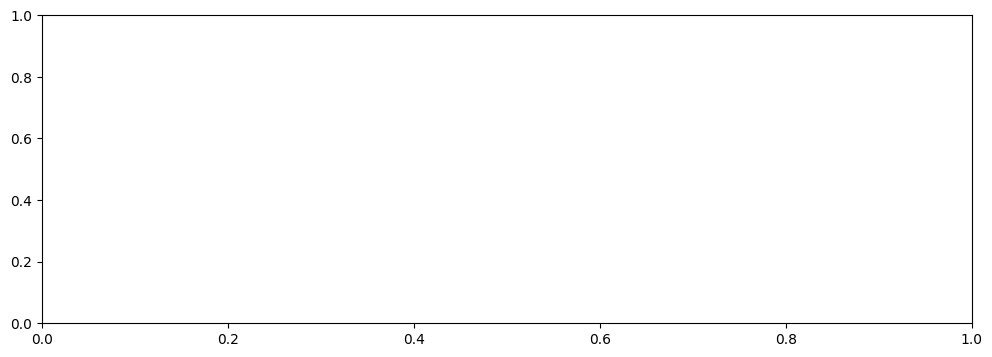

In [19]:
# # Dibujar circuito cuántico si aplica
# if config['quantum']:
#     n_qubits = config['n_qubits']
#     q_depth = config['q_depth']
#     # Crear figura con estilo default
#     dummy_weights = torch.zeros((q_depth, n_qubits))
#     dummy_input = torch.zeros(n_qubits)
#     # Dibujar capa cuántica aislada
#     fig, ax = plt.subplots(figsize=(12,4))
#     drawer = qml.draw_mpl(lambda x, w: build_quantum_layer(n_qubits, q_depth)(x), show_all_wires=True)
#     drawer(dummy_input, dummy_weights)
#     plt.title('Circuito Cuántico Variacional')
#     path = os.path.join(config['model_dir'], 'quantum_circuit.png')
#     plt.savefig(path)
#     plt.close()
#     print(f'✅ Circuito guardado en {path}')
# else:
#     print('ℹ️ Modelo clásico: no se visualiza circuito cuántico')


## 🚀 Entrenamiento del Modelo

Se define una función `train_model` que implementa un bucle de entrenamiento típico:  
1. **Forward** sobre el conjunto de entrenamiento y cálculo de loss.  
2. **Backpropagation** y actualización de pesos mediante un optimizador.  
3. Evaluación en el conjunto de validación para monitorizar el overfitting.  

El mejor modelo (según la métrica de validación) se almacena y se devuelve al final. Durante el entrenamiento se registran las curvas de loss y accuracy para `train` y `val`, y se guardan en gráficos.  

Se utiliza `CrossEntropyLoss` como función de pérdida y `Adam` como optimizador. También se incorpora un `StepLR` para ajustar la tasa de aprendizaje.


In [20]:
# Training
print('Starting training...')
model_hybrid, history = train_model(
    model_hybrid,
    dataloaders,
    dataset_sizes,
    device,
    config['num_epochs'],
    config['learning_rate'],
    config['model_dir']
)

metrics_path = os.path.join(config['model_dir'], 'metrics.json')
with open(metrics_path, 'w') as f:
  json.dump({
      'train_losses': history.get('train_loss', []),
      'train_accs': history.get('train_acc', []),
      'test_losses': history.get('test_loss', []),
      'test_accs': history.get('test_acc', [])
  }, f, indent=4)

  print(f"Metrics saved to {metrics_path}")

Starting training...
Epoch 1/15
------------------------------
train Loss: 0.6092 Acc: 0.6537
test Loss: 0.4166 Acc: 0.8878

Epoch 2/15
------------------------------
train Loss: 0.3380 Acc: 0.9174
test Loss: 0.3295 Acc: 0.8976

Epoch 3/15
------------------------------
train Loss: 0.2619 Acc: 0.9292
test Loss: 0.2363 Acc: 0.9252

Epoch 4/15
------------------------------
train Loss: 0.2179 Acc: 0.9365
test Loss: 0.2362 Acc: 0.9232

Epoch 5/15
------------------------------
train Loss: 0.2082 Acc: 0.9337
test Loss: 0.2034 Acc: 0.9291

Epoch 6/15
------------------------------
train Loss: 0.1907 Acc: 0.9359
test Loss: 0.1632 Acc: 0.9469

Epoch 7/15
------------------------------
train Loss: 0.1651 Acc: 0.9438
test Loss: 0.1524 Acc: 0.9508

Epoch 8/15
------------------------------
train Loss: 0.1757 Acc: 0.9410
test Loss: 0.1932 Acc: 0.9291

Epoch 9/15
------------------------------
train Loss: 0.1517 Acc: 0.9477
test Loss: 0.1836 Acc: 0.9350

Epoch 10/15
------------------------------


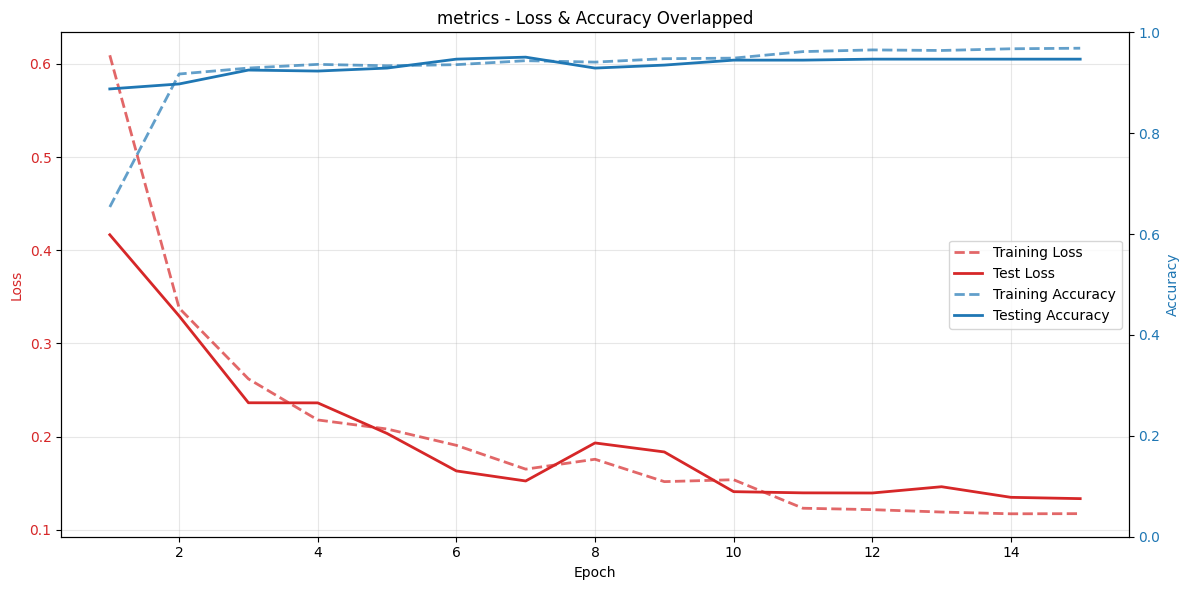


Model statistics for metrics:
  Best Test Loss: 0.1335
  Best Test Accuracy: 0.9508
  Epochs trained: 15


In [21]:
# Metrics visualization
metrics_json = os.path.join(config["model_dir"], "metrics.json")
plot_overlapped_metrics(metrics_json, figsize=(12, 6))

## 📊 Evaluación sobre el Conjunto de Test

Tras el entrenamiento, evaluamos el modelo sobre el conjunto de *test* (si existe) y calculamos métricas cuantitativas:

- **Accuracy general**
- **Precisión**, **recall** y **F1-score** (promedio ponderado)
- **Matriz de confusión**

La evaluación queda registrada en un archivo `test_metrics.json` y se genera una figura `confusion_matrix.png` en el directorio de la corrida.


In [22]:
# Evaluation
test_metrics = None
val_metrics = None
if 'val' in dataloaders and dataset_sizes.get('val', 0) > 0:
  print("Evaluating on validation set...")
  val_metrics = evaluate_model(
      model_hybrid,
      dataloaders['val'],
      class_names,
      device,
      config['model_dir'],
      split_name="val"
  )
else:
  print("No validation split defined.")

if 'test' in dataloaders and dataset_sizes.get('test', 0) > 0:
  print("Evaluating on test set...")
  test_metrics = evaluate_model(
      model_hybrid,
      dataloaders['test'],
      class_names,
      device,
      config['model_dir'],
      split_name="test"
  )
else:
  print("No test split defined.")

Evaluating on validation set...
VAL metrics saved to /content/drive/MyDrive/CREMAD/Models/emb_resnet18/emb_resnet18_quantum/run_11-27_23-23-28/val_metrics.json
VAL Accuracy: 0.9449 | F1: 0.9449
Confusion matrix saved to /content/drive/MyDrive/CREMAD/Models/emb_resnet18/emb_resnet18_quantum/run_11-27_23-23-28/confusion_matrix_val.png
Evaluating on test set...
TEST metrics saved to /content/drive/MyDrive/CREMAD/Models/emb_resnet18/emb_resnet18_quantum/run_11-27_23-23-28/test_metrics.json
TEST Accuracy: 0.9469 | F1: 0.9469
Confusion matrix saved to /content/drive/MyDrive/CREMAD/Models/emb_resnet18/emb_resnet18_quantum/run_11-27_23-23-28/confusion_matrix_test.png


## ✅ Conclusiones y Próximos Pasos

Este cuaderno presenta una pipeline completa para la clasificación de emociones en el dataset CREMA-D utilizando modelos clásicos y cuánticos.  
Las mejoras implementadas incluyen:

- **Gestión automática de hiperparámetros** y guardado de configuración en JSON.
- **Organización de directorios de salida** por modelo y tipo (clásico/cuántico) con un identificador de corrida.
- **Funciones de carga de datos** que soportan imágenes, embeddings y MFCCs, con filtro de clases.
- **Arquitecturas modulares** que permiten seleccionar entre redes preentrenadas, CNN personalizadas y capas cuánticas.
- **Entrenamiento con registro de curvas** de pérdida y precisión, y guardado de mejores pesos.
- **Evaluación en el conjunto de test** con métricas estándar y matriz de confusión.

Puedes continuar experimentando modificando `base_model`, activando o desactivando la capa cuántica, ajustando `n_qubits` y `q_depth`, o filtrando un subconjunto de emociones mediante `selected_classes`.  
Recuerda revisar el directorio `Models/` en tu Drive para explorar los resultados guardados de cada ejecución.

---

### 🔁 Sección Deprecada / Legacy

A continuación se incluyen algunas funciones y celdas del cuaderno original que ya no forman parte del flujo principal pero se mantienen por referencia histórica. Puedes consultar su código para entender versiones anteriores o para reutilizar fragmentos en otros contextos. *No influyen en la ejecución actual.*


In [ ]:
# ❗ Deprecated: Código heredado

# # Función mejorada para crear dataloaders
# def create_dataloaders_enhanced(data_dir, batch_size=8, shuffle=True, num_workers=4, grayscale=False, force_three_channels=False):
#     """
#     Crea dataloaders con análisis detallado de clases.
#
#     Args:
#         data_dir: Directorio con subcarpetas 'train' y 'val'
#         batch_size: Tamaño del batch
#         shuffle: Mezclar datos de entrenamiento
#         num_workers: Número de workers para DataLoader
#         grayscale: Convertir a escala de grises
#         force_three_channels: Si True, duplica canal gris a 3 canales
#
#     Returns:
#         dataloaders, dataset_sizes, class_names, counts_per_class
#     """
#     # Estadísticas de normalización
#     if grayscale and not force_three_channels:
#         mean, std = [0.5], [0.5]
#     else:
#         mean = [0.485, 0.456, 0.406]
#         std = [0.229, 0.224, 0.225]
#
#     # Pipeline de transformaciones
#     transform_list = [transforms.Resize((224, 224))]
#     if grayscale:
#         # Si usamos backbones preentrenados, repetimos el canal a 3
#         if force_three_channels:
#             transform_list.append(transforms.Grayscale(num_output_channels=3))
#         else:
#             transform_list.append(transforms.Grayscale(num_output_channels=1))
#     transform_list += [
#         transforms.ToTensor(),
#         transforms.Normalize(mean, std)
#     ]
#     data_transform = transforms.Compose(transform_list)
#
#     # Crear datasets
#     image_datasets = {
#         phase: datasets.ImageFolder(os.path.join(data_dir, phase), transform=data_transform)
#         for phase in ['train', 'val']
#     }
#
#     # Crear dataloaders
#     dataloaders = {
#         phase: DataLoader(
#             image_datasets[phase],
#             batch_size=batch_size,
#             shuffle=(shuffle if phase == 'train' else False),
#             num_workers=num_workers
#         )
#         for phase in ['train', 'val']
#     }
#
#     # Información del dataset
#     dataset_sizes = {phase: len(image_datasets[phase]) for phase in ['train', 'val']}
#     class_names = image_datasets['train'].classes
#
#     # Conteo por clase
#     counts_per_class = {
#         phase: count_images_per_class_from_dataset(image_datasets[phase], class_names)
#         for phase in ['train', 'val']
#     }
#
#     return dataloaders, dataset_sizes, class_names, counts_per_class
#
# print("✅ Función de carga de datos definida")
#